In [201]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
def f(x):
    return 3*x**2 - 4 * x + 5

f(3.0)

xs = np.arange(-5, 5, 0.25)
ys = f(xs)

plt.plot(xs, ys)

In [ ]:
h = 0.000001
x = -3
(f(x+h) - f(x))/h

In [ ]:
# Let's get more complex
a = 2
b = -3.0
c = 10
d = a*b+c
print(d)

In [ ]:
h = 0.00001
a = 2
b = -3.0
c = 10

d1 = a*b+c
b += h
d2 = a*b+c

print('d1', d1)
print('d2', d2)
print('slope', (d2-d1)/h)

In [202]:
from collections.abc import Callable

class Value():

    def __init__(self, data: float, _children: tuple = (), _op: str = '', label='') -> None:
        self.data = data
        self.grad = 0.0
        self._prev: set[Value] = set(_children)
        self._backward: Callable[[], float] = lambda: None
        self._op = _op
        self.label = label
    
    def __repr__(self) -> str:
        return f"Value(data={self.data}, prev=len({len(self._prev)}), op={self._op})"
    
    def __add__(self, other: Value | float | int) -> 'Value':
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')

        def backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad

        out._backward = backward
        return out
    
    def __radd__(self, other: Value | float | int) -> 'Value':
        return self.__add__(other)

    def __neg__(self) -> 'Value':
        return self * -1

    def __sub__(self, other: Value | float | int) -> 'Value':
        return self + (-other)
    
    def __rsub__(self, other: Value | float | int) -> 'Value':
        return self.__sub__(other)

    def __mul__(self, other: Value | float | int) -> 'Value':
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')

        def backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad

        out._backward = backward
        return out
    
    def __rmul__(self, other: Value | float | int) -> 'Value':
        return self.__mul__(other)

    def __truediv__(self, other: Value | float | int) -> 'Value':
        other = other if isinstance(other, Value) else Value(other)
        return self * other ** -1
    
    def __rtruediv__(self, other: Value | float | int) -> 'Value':
        return self.__truediv__(other)

    def exp(self) -> 'Value':
        x = self.data
        t = math.exp(x)
        out = Value(math.exp(x), (self, ), 'exp')

        def backward():
            self.grad += out.data * out.grad

        out._backward = backward
        return out

    def __pow__(self, other: Value | float | int) -> 'Value':
        if not isinstance(other, float) and not isinstance(other, int):
            raise ValueError(f"Value can only be raised to a number, got: {other}")
        other = other if isinstance(other, Value) else Value(other)
        out = Value(math.pow(self.data, other.data), (self, other), 'pow')

        def backward():
            # c = a ^ b
            #
            # dc/da = b * a ^ (b-1)
            # dc/db = ln(a) * a ^ b
            self.grad += other.data * (self.data ** (other.data - 1)) * out.grad
            other.grad += math.log(self.data) * (self.data ** other.data) * out.grad

        out._backward = backward
        return out
    
    def __rpow__(self, other: Value | float | int) -> 'Value':
        return self.__pow__(other)
    
    def tanh(self) -> 'Value':
        # (e^2*x+1) / (e^2*x - 1)
        # Note that these methods all implement backprop themselves
        e = (2.0 * self).exp()
        return (e - 1.0) / (e + 1.0)
    
    def backward(self) -> None:
        visited: set[Value] = set()
        topo: list[Value] = []

        def build_topo(v: Value) -> list[Value]:
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)

        build_topo(self)

        self.grad = 1
        for node in reversed(topo):
            node._backward()
    
    @property
    def uid(self) -> str:
        """Return a unique id for the node"""
        return str(id(self))

    @property
    def op(self) -> str:
        """Return a printable label for the operation edge of the node"""
        return self._op

    @property
    def op_uid(self) -> str:
        """Return a printable label for the operation edge of the node"""
        return self.uid + self.op

    @property
    def data_label(self) -> str:
        """Return a printable label for the node"""
        return "{ %s | data %.4f | grad %.4f}" % (self.label, self.data, self.grad)

In [203]:
from graphviz import Digraph

def trace(root: Value) -> tuple[set[Value], set[tuple[Value, Value]]]:
    nodes: set[Value] = set()
    edges: set[tuple[Value, Value]] = set()

    def build(v: Value):
        if v in nodes:
            return
        nodes.add(v)
        for child in v._prev:
            edges.add((child, v))
            build(child)

    build(root)
    return nodes, edges

def draw_dot(root: Value):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'})

    nodes, edges = trace(root)
    for node in nodes:
        dot.node(name=node.uid, label=node.data_label, shape="record")
        # Add synthetic operation nodes when present
        if node.op:
            dot.node(name=node.op_uid, label=node.op)
            dot.edge(node.op_uid, node.uid)

    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot


# Back propagation through a neuron

In [208]:
# Inputs x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# Weights w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# Bias
b = Value(6.8813735870195432, label='b')

# x1w1 + x2w2 + b
x1w1 = x1*w1
x1w1.label = 'x1*w1'
x2w2 = x2*w2
x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2
x1w1x2w2.label = 'x1*w1 + x2*w2'
# Cell body raw activation w/o activation function for now
n = x1w1x2w2 + b
n.label = 'n'
o = n.tanh()
o.label = 'o'

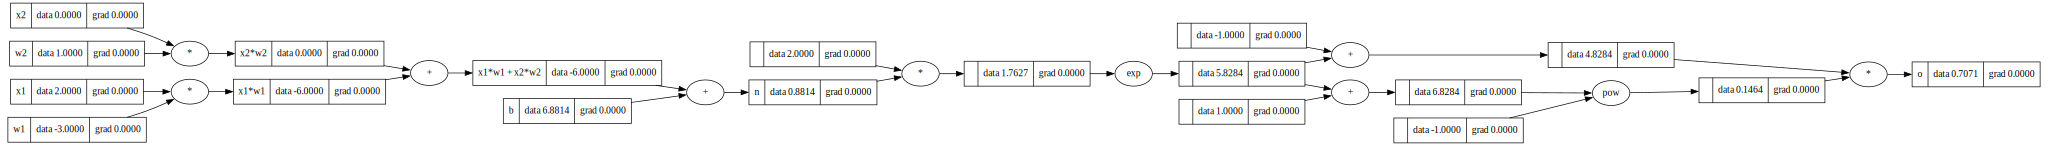

In [209]:
draw_dot(o)


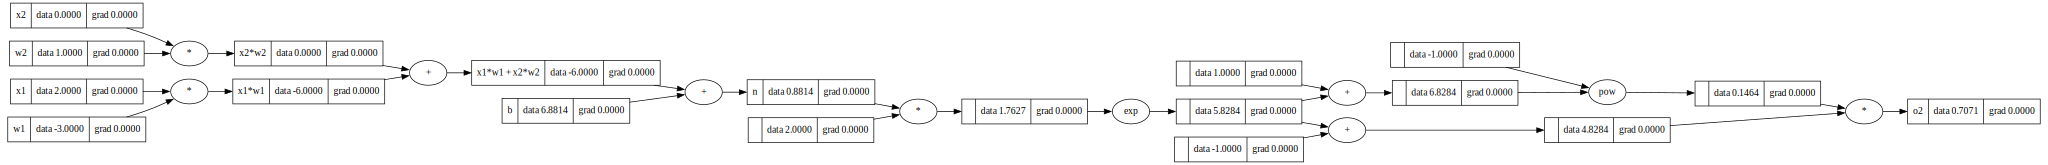

In [211]:
o2 = n.tanh()
o2.label = 'o2'
draw_dot(o2)

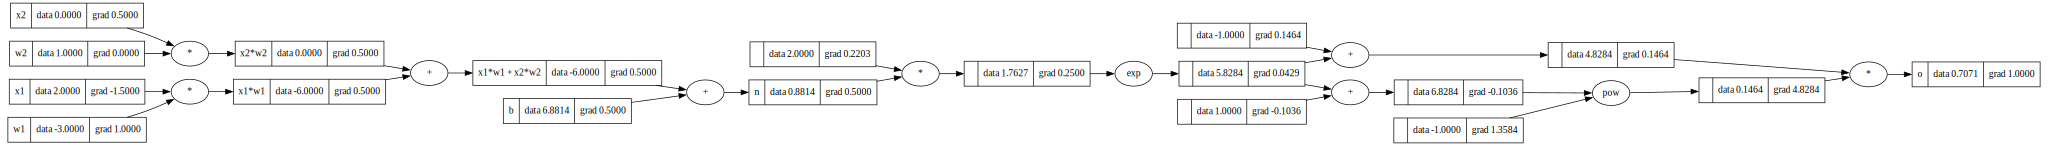

In [212]:

o.backward()
draw_dot(o)

# Using pytorch

In [231]:
import torch

# Casting to double for compat with earlier exercise.

# Inputs x1, x2
x1 = torch.tensor([2.0]).double()
x1.requires_grad = True
x2 = torch.tensor([0.0]).double()
x2.requires_grad = True
print('x2=', x2.data.item())

# Weights w1, w2
w1 = torch.tensor([-3.0]).double()
w1.requires_grad = True
w2 = torch.tensor([1.0]).double()
w2.requires_grad = True
print('w2=', w2.data.item())

# Bias
b = torch.tensor([6.8813735870195432]).double()
b.requires_grad = True

n = x1*w1 + x2*w2 + b

o = torch.tanh(n)

print(o.data.item())
o.backward()

print('---')
print('x1', x1.grad.item())
print('w1', w1.grad.item())
print('x2', x2.grad.item())
print('w2', w2.grad.item())


x2= 0.0
w2= 1.0
0.7071066904050358
----grad----
x1 -1.5000003851533106
w1 1.0000002567688737
x2 0.5000001283844369
w2 0.0
